# Generating the cluster number density

We will compute the cluster number density, $n(s, p)$, from sets of percolating two-dimensional clusters. As the cluster number density is not known analytically in all but the simplest systems, i.e., the infinite dimensional and the one-dimensional system, we will estimate it numerically. This is done by
\begin{align}
    n(s, p; L) \approx \frac{N_s}{ML^d},
\end{align}
where $s$ is the size of the cluster, $p$ the probability for a site to be set in the system, $L$ the length of a side in the system (assuming equal lengths for all sides), $d$ the dimension of the problem ($L^d$ is the volume), $N_s$ the number of clusters of size $s$ and $M$ the number of simulations performed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage
import tqdm
import sklearn.linear_model

In [2]:
def is_percolating(prop, num_rows, num_cols):
    min_row, min_col, max_row, max_col = prop.bbox

    return max_row - min_row == num_rows or max_col - min_col == num_cols

In [3]:
def compute_cluster_area(system, p, remove_percolating_cluster=True):
    mat = system < p
    # Label and count the number of connected clusters
    labels, num_features = scipy.ndimage.measurements.label(mat)
    s_list = skimage.measure.regionprops(labels)

    new_s_list = []
    if remove_percolating_cluster:
        for s in s_list:
            if is_percolating(s, *system.shape):
                continue
            new_s_list.append(s)
    else:
        new_s_list = s_list
            
    area = list(map(lambda prop: prop.area, new_s_list))

    return area

Example code to plot a specific prop in a system.

```python
box = s[1].bbox
plt.matshow(labels[box[0]:box[2], box[1]:box[3]], cmap="hsv")
plt.show()
```

In [4]:
def compute_cluster_number_density(L, M, p, a=1.2):
    area = []
    for i in range(M):
        z = np.random.rand(L, L)
        area.extend(compute_cluster_area(z, p))

    n, s = np.histogram(area, L ** 2)

    nsp = n / (L ** 2 * M)

    # Logarithmic binning
    logamax = np.ceil(np.log(max(s)) / np.log(a))
    bins = a ** np.arange(0, logamax, 1)

    nl, _ = np.histogram(area, bins)
    ds = np.diff(bins)
    sl = (bins[1:] + bins[:-1]) * 0.5
    nsl = nl / (M * L ** 2 * ds)

    return sl, nsl

Below we plot the cluster number density as $p \to p_c = 0.59275$ from below.

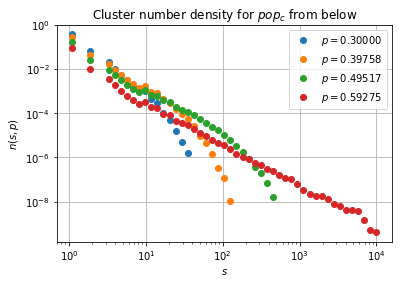

In [5]:
for p in np.linspace(0.3, 0.59275, 4):
    plt.loglog(
        *compute_cluster_number_density(200, 100, p),
        "o",
        label=rf"$p = {p:.5f}$"
    )

plt.legend()
plt.grid()
plt.title("Cluster number density for $p \to p_c$ from below")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

In this figure we can see how the cluster number density follows a seemingly straight line for a while, before dropping of sharply when $p$ is a little off from the critical percolation probability.

Here we repeat the experiment, but for $p \to p_c$ from above.

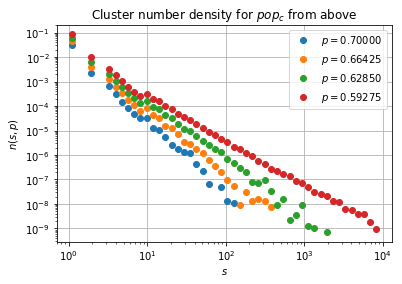

In [6]:
for p in reversed(np.linspace(0.59275, 0.7, 4)):
    plt.loglog(
        *compute_cluster_number_density(200, 100, p),
        "o",
        label=rf"$p = {p:.5f}$"
    )

plt.legend()
plt.grid()
plt.title("Cluster number density for $p \to p_c$ from above")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

## The cluster number density at critical percolation probability

For $p = p_c = 0.59275$, we explore how the cluster number density changes for a system of $L = 2^k$ for $k = \{4, \dots, 9\}$. We wish to show how the cluster number density deviates from the power law behavior, when $p = p_c$. We expect that
\begin{align}
    n(s, p_c; L) \propto s^{-\tau}.
\end{align}
By taking the logarithm on both sides, we get an expression for $\tau$.
\begin{gather}
    \log\left[n(s, p_c; L)\right] \propto -\tau \log\left[ s \right].
\end{gather}
We use linear regression to get an estimate for $-\tau$.

In [7]:
L_arr = 2 ** np.arange(4, 10)
p_c = 0.59275

In [10]:
for L in tqdm.tqdm_notebook(L_arr):
    sl, nsl = compute_cluster_number_density(L, 100, p=p_c)

    clf = sklearn.linear_model.LinearRegression(
        fit_intercept=True
    ).fit(sl[:, None], nsl[:, None])

    tau = clf.coef_[0, 0]

    print(f"For L = {L}: -tau = {tau}")

For L = 16: -tau = -0.0002665795003324802
For L = 32: -tau = -4.1516921681746244e-05
For L = 64: -tau = -6.337717147611106e-06
For L = 128: -tau = -1.360304058052091e-06
For L = 256: -tau = -3.790406331304759e-07
For L = 512: -tau = -7.243462911378661e-08

